In [1]:
# Install SAM and necessary dependencies
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

torch.cuda.is_available()

Mounted at /content/drive


True

In [3]:
# CHECKPOINT downloading
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-07-10 13:10:17--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.25, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   186MB/s    in 25s     

2024-07-10 13:10:43 (97.7 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [4]:
# Define model type and checkpoint path
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"

# Load the model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Init mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

/content/drive/MyDrive/KernelGAN-Masks/imgs/img1
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/imgs/img2
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_lr_mask.png


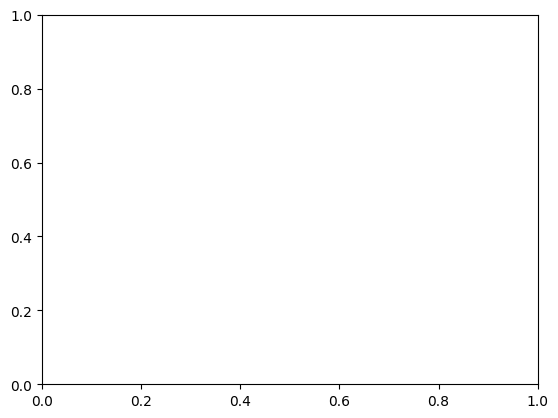

In [10]:
# Assuming mask_generator is an instance of some class capable of generating masks
def extract_numbers_from_filename(filename):
    # Use regular expression to find numbers in the filename
    match = re.search(r'\d+', filename)

    # If numbers are found, convert them to an integer
    if match:
        return int(match.group())
    else:
        return None

def create_masks(result_dict, axes=None, masks_num=None):
    if axes:
      ax = axes
    else:
      ax = plt.gca()
      ax.set_autoscale_on(False)
    if not masks_num:
      masks_num = len(result_dict)
    sorted_result = sorted(result_dict, key=lambda x: x['area'], reverse=True)
    sorted_result = sorted_result[:masks_num]
    return sorted_result


def extract_largest_component(mask):
    # Convert boolean array to a binary image (0 and 255)
    true_map_binary = (mask * 255).astype(np.uint8)

    # Apply morphological operations to remove small noise
    kernel = np.ones((8, 8), np.uint8)
    true_map_binary = cv2.morphologyEx(true_map_binary, cv2.MORPH_CLOSE, kernel)

    # Use connectedComponentsWithStats to find all connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(true_map_binary)

    # The first component is the background, so we start with the second one
    largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Create a new mask for the largest component
    largest_component_mask = (labels == largest_component).astype(np.uint8) * 255

    return largest_component_mask

def create_mask(image_path):
    image_rgb = cv2.imread(image_path)

      # Generate segmentation mask
    output_mask = mask_generator.generate(image_rgb)

            # Create a mask for the largest component
    masks = create_masks(output_mask)
    mask = masks[0]['segmentation']
    largest_component_mask = extract_largest_component(mask)
    return largest_component_mask

# do the code aobve for all the imgs in the src folder
base = "/content/drive/MyDrive/KernelGAN-Masks"
src = base + "/imgs"
dst = base + "/masks"

files = os.listdir(src)

for file_name in files:
    image_path = os.path.join(src, file_name)
    img_num = extract_numbers_from_filename(file_name)
    dir_path = os.path.join(dst, 'img' + str(img_num))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    print(image_path)

    for img in os.listdir(image_path):
        if "lr" in img:
            image_path_lr = os.path.join(image_path, img)
            break

    lr_back = create_mask(image_path_lr)
    new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
    new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
    new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
    new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

    hr_back = cv2.resize(lr_back, dsize=(lr_back.shape[1]*2, lr_back.shape[0]*2), interpolation=cv2.INTER_CUBIC)
    hr_obj = cv2.bitwise_not(hr_back)
    lr_obj = cv2.bitwise_not(lr_back)

    cv2.imwrite(new_path_back_hr, hr_back)
    cv2.imwrite(new_path_back_lr, lr_back)
    cv2.imwrite(new_path_obj_hr, hr_obj)
    cv2.imwrite(new_path_obj_lr, lr_obj)

    print(new_path_back_hr)
    print(new_path_back_lr)
    print(new_path_obj_hr)
    print(new_path_obj_lr)
